## EDMD

For people already familiar with the method and interface, the [API docs](../api/generated/deeptime.decomposition.EDMD.rst).

Similarly to DMD, extended DMD (EDMD) <cite data-cite="nbedmd-williams2015data">(Williams, 2015)</cite> is a data-driven method to approximate the Koopman operator. The Koopman operator $\mathcal{K}$ describes how an observable of an (potentially stochastic) dynamical system evolves in time. In a discrete-time setting with $x_{t+1} = T(x_t)$ and an observable $g$, the Koopman operator is defined as

$$
(\mathcal{K} g)(x) = g(T(x)).
$$

Given observation data $X$ and $Y$, where $y_i = T(x_i)$ and a basis set of functions or observables

$$
B = \{ \psi_1,\psi_2,\ldots,\psi_k \},
$$

one can define the transformed data $\Psi_X$ and $\Psi_Y$ with 

$$(\Psi_*)_i = (\psi_1(*_i),\ldots, \psi_k(*_i))^\top, $$

yielding

$$
\Psi_Y^\top = \Psi_X^\top K.
$$

Here, $K^\top\in\mathbb{R}^{k\times k}$ acting from the left is the projection of the true Koopman operator $\mathcal{K}$ into the basis $B$.

Usually one performs rank-truncation or has over-/underdetermined systems. In such cases, $K$ is determined via the pseudo-inverse $K=\Psi_Y\Psi_X^\dagger$.

In case of a basis $B$ which just contains the identity, EDMD reduces back to DMD.

To demonstrate EDMD and deeptime's API, we consider a [two-dimensional triple-well potential](../api/generated/deeptime.data.triple_well_2d.rst#deeptime.data.triple_well_2d) <cite data-cite="nbedmd-schutte2013metastability">(Schütte, 2013)</cite>. It is defined on $[-2,2]\times [-1, 2]$ and looks like the following:

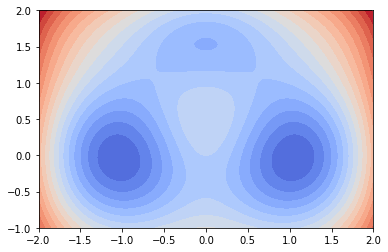

In [1]:
import deeptime as dt
import numpy as np
import matplotlib.pyplot as plt

system = dt.data.triple_well_2d()

x = np.linspace(-2, 2, num=100)
y = np.linspace(-1, 2, num=100)
XX, YY = np.meshgrid(x, y)
coords = np.dstack((XX, YY)).reshape(-1, 2)
V = system.potential(coords).reshape(XX.shape)

plt.contourf(x, y, V, levels=np.linspace(-4.5, 4.5, 20), cmap='coolwarm');

Inside this potential landscape we integrate particles subject to the stochastic differential equation

$$ \mathrm{d}X_t = \nabla V(X_t) \mathrm{d}t + \sigma(t, X_t)\mathrm{d}W_t $$

with $\sigma=1.09$, using an Euler-Maruyama integrator.

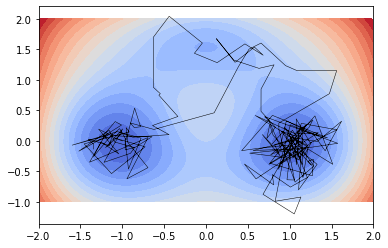

In [2]:
traj = system.trajectory(x0=[[-1, 0]], n_evaluations=200, seed=66)

plt.contourf(x, y, V, levels=np.linspace(-4.5, 4.5, 20), cmap='coolwarm')
plt.plot(*traj.T, c='black', lw=.5);

To approximate the Koopman operator, we first select 25000 random points inside the domain and integrate them for 10000 steps under an integration step of $h=10^{-5}$:

In [3]:
N = 25000
state = np.random.RandomState(seed=42)
X = np.stack([state.uniform(-2, 2, size=(N,)), state.uniform(-1, 2, size=(N,))]).T
Y = system(X, n_jobs=8)

Now we pick a basis $B$ to be all monomials up to and including degree $\mathrm{deg}=10$.

In [4]:
basis = dt.basis.Monomials(p=10, d=2)

Using this basis, we can fit an EDMD estimator and obtain the corresponding model.

In [5]:
edmd_estimator = dt.decomposition.EDMD(basis, n_eigs=8)
edmd_model = edmd_estimator.fit((X, Y)).fetch_model()

We can obtain the dominant eigenvalues associated to processes in the system.

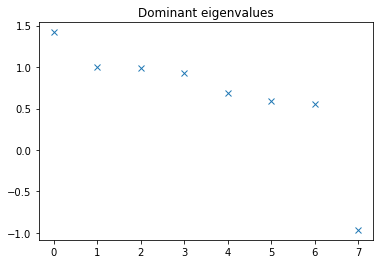

In [6]:
plt.plot(np.real(edmd_model.eigenvalues), 'x')
plt.title('Dominant eigenvalues');

We project our input data $X$ using the eigenfunctions:

In [7]:
phi = np.real(edmd_model.transform(X))

# normalize
for i in range(len(edmd_model.eigenvalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

And visualize the first four eigenfunctions. They contain information about metastable regions and slow transitions.

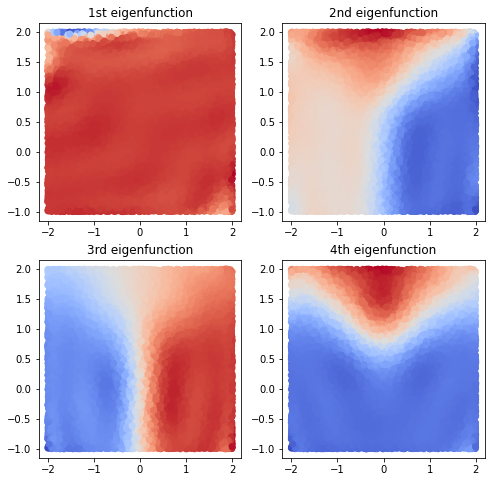

In [8]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(ncols=2, nrows=2)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(*X.T, c=phi[:, 0], cmap='coolwarm')
ax.set_title('1st eigenfunction')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(*X.T, c=phi[:, 1], cmap='coolwarm')
ax.set_title('2nd eigenfunction')

ax = fig.add_subplot(gs[1, 0])
ax.scatter(*X.T, c=phi[:, 2], cmap='coolwarm')
ax.set_title('3rd eigenfunction')

ax = fig.add_subplot(gs[1, 1])
ax.scatter(*X.T, c=phi[:, 3], cmap='coolwarm')
ax.set_title('4th eigenfunction');

Using a clustering can reveal temporally coherent structures.

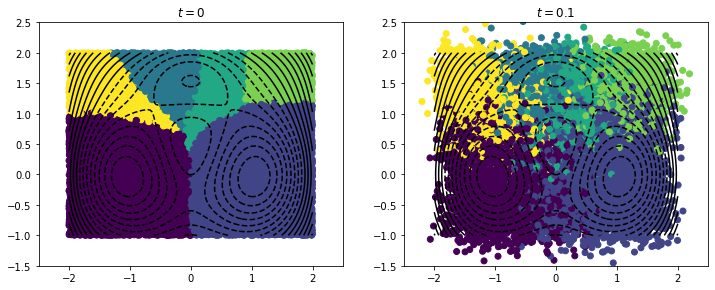

In [9]:
kmeans = dt.clustering.Kmeans(n_clusters=6, n_jobs=4).fit(np.real(phi)).fetch_model()
c = kmeans.transform(np.real(phi))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(*X.T, c=c)
ax1.set_title(r"$t = 0$")
ax1.set_aspect('equal')
ax1.set_xlim([-2.5, 2.5])
ax1.set_ylim([-1.5, 2.5])
ax1.contour(x, y, V, levels=np.linspace(-4.5, 4.5, 20), colors='black')

ax2.scatter(*Y.T, c=c)
ax2.set_title(r"$t = 0.1$")
ax2.set_aspect('equal')
ax2.set_xlim([-2.5, 2.5])
ax2.set_ylim([-1.5, 2.5])
ax2.contour(x, y, V, levels=np.linspace(-4.5, 4.5, 20), colors='black');